In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp 
import tensorflow as tf
import h5py
from sklearn.metrics import roc_curve, auc

import os
os.chdir('..')

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

2024-07-29 19:28:36.350639: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 19:28:36.402928: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 19:28:37.230427: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
import math
def mse_loss(y_true, y_pred):
    return tf.math.reduce_mean(tf.math.square(y_pred-y_true), axis=-1)
    
def mse_loss2(y_true,y_pred):

    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, dtype=tf.float32)
    # trick with phi
    y_pred_phi = math.pi*tf.math.tanh(y_pred)
    # trick with phi
    y_pred_eta_egamma = 3.0*tf.math.tanh(y_pred)
    y_pred_eta_muons = 2.1*tf.math.tanh(y_pred)
    y_pred_eta_jets = 4.0*tf.math.tanh(y_pred)
    y_pred_eta = tf.concat([y_pred[:,0:1,:,:], y_pred_eta_egamma[:,1:5,:,:], y_pred_eta_muons[:,5:9,:,:], y_pred_eta_jets[:,9:19,:,:]], axis=1)
    # use both tricks
    y_pred = tf.concat([y_pred[:,:,0,:], y_pred_eta[:,:,1,:], y_pred_phi[:,:,2,:]], axis=2)
    # mask zero features
    mask = tf.math.not_equal(y_true,0)
    mask = tf.cast(mask, tf.float32)
    y_pred = mask * y_pred

 
    loss = masked_mse(tf.expand_dims(y_true, 3), tf.expand_dims(y_pred, 3)) #mse_loss(tf.reshape(y_true, [-1, 57]), tf.reshape(y_pred, [-1, 57]))
    #loss = tf.math.reduce_mean(loss, axis=0) # average over batch
    return loss


def masked_mse(A, B):

    
    
    mask = tf.reduce_all(A[:,:,0] != 0, axis=[2])  
    mask = tf.cast(mask, A.dtype)  
    mask = tf.expand_dims(tf.expand_dims(mask, -1), -1)  


    A_masked = A * mask
    B_masked = B * mask

    squared_diff = tf.square(A_masked - B_masked)


    sum_squared_diff = tf.reduce_sum(squared_diff, axis=[1, 2, 3])  
    sum_mask = tf.reduce_sum(mask, axis=[1, 2, 3])  


    mse = sum_squared_diff / sum_mask

    return mse

In [6]:
def get_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(19, 3, 1))
    x = layers.ZeroPadding2D((1,0))(encoder_inputs)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(16,(3,3), padding = 'valid')(x)
    x = layers.ReLU()(x)
    x = layers.AveragePooling2D((3,1))(x)

    x = layers.Conv2D(32,(3,1), padding = 'same')(x)
    x = layers.ReLU()(x)
    x = layers.AveragePooling2D((3,1))(x)
    x = layers.Flatten()(x)

    x = layers.Dense(latent_dim)(x)

    return keras.Model(encoder_inputs, x)

def get_decoder(latent_dim):
    latent_inputs = latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Dense(64)(latent_inputs)
    x = layers.ReLU()(x)
    x = layers.Reshape((2,1,32))(x)

    x = layers.Conv2D(32, (3,1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D((3,1))(x)
    x = layers.ZeroPadding2D(((0,0),(1,1)))(x)

    x = layers.Conv2D(16, (3,1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D((3,1))(x)
    x = layers.ZeroPadding2D(((1,0),(0,0)))(x)

    x = layers.Conv2D(1, (3,3), padding='same')(x)
    
    return keras.Model(latent_inputs, x)
    
def get_ae(latent_dim):
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(19, 3, 1))
    
    encoder_outputs = encoder(inputs)
    reconstructions = decoder(encoder_outputs)
    
    return keras.Model(inputs, reconstructions)


In [7]:
with h5py.File('signals/convolutional_dataset.h5', 'r') as file:
    x_train = np.array(file['X_train'])
    x_test = np.array(file['X_test'])
    x_val = np.array(file['X_val'])

In [9]:
#with tf.device('/CPU:0'):
#    x_train = tf.convert_to_tensor(x_train)
#x_train = x_train[:1000000]
model = get_ae(8)
model.compile(loss=mse_loss2, optimizer=keras.optimizers.Adam())
#model.fit(x_train, x_train)
print(x_train.shape)
model.fit(x_train, x_train, epochs=40, batch_size=1024, callbacks=[
    keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, min_delta = 0.00),
    keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=1)])
model.save("CNNautoencoder.keras")

(8609225, 19, 3, 1)
Epoch 1/40
8402/8408 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 152.4284

I0000 00:00:1722281571.126034     381 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1756', 4 bytes spill stores, 4 bytes spill loads



8408/8408 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 152.3460 - learning_rate: 0.0010
Epoch 2/40
8408/8408 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 15.2131 - learning_rate: 0.0010
Epoch 3/40
8408/8408 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 13.5578 - learning_rate: 0.0010
Epoch 4/40
8408/8408 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 11.6949 - learning_rate: 0.0010
Epoch 5/40
8408/8408 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 8.8302 - learning_rate: 0.0010
Epoch 6/40
8408/8408 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 7.8419 - learning_rate: 0.0010
Epoch 7/40
8408/8408 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 6.5112 - learning_rate: 0.0010
Epoch 8/40
8408/8408 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 5.8615 - learning_rate: 0.0010
Epoch 9/40
8408/8408 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 5.0230 - learning_rate: 0.0010
Epoch 10/40
8408/8408 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 4.3868 - learning_rate: 0.0010
Epoch 11/40
8408/8408 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 4

In [10]:
x_test = x_test
vqvae = model
bkg_prediction = vqvae.predict(x_test)
signal_labels = ["Ato4l", "LQtoBTau", "hToTauTau", "hChToTauNu"]
signals_file = ["signals/Ato4l_dataset.h5","signals/LQtoBTau_dataset.h5", "signals/hToTauTau_dataset.h5", "signals/hChToTauNu_dataset.h5"]

signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file['Data'])
    signal_data.append(test_data)
    
signal_results = []
for i, label in enumerate(signal_labels):
    signal_prediction = vqvae.predict(signal_data[i])
    signal_results.append([label, signal_data[i], signal_prediction])

84075/84075 ━━━━━━━━━━━━━━━━━━━━ 54s 635us/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step
10642/10642 ━━━━━━━━━━━━━━━━━━━━ 7s 610us/step
21603/21603 ━━━━━━━━━━━━━━━━━━━━ 14s 656us/step
23759/23759 ━━━━━━━━━━━━━━━━━━━━ 15s 635us/step


In [11]:
with h5py.File('results.h5', 'w') as file:
    file.create_dataset('BKG_input', data=x_test)
    file.create_dataset('BKG_predicted', data=bkg_prediction)
    for i, sig in enumerate(signal_results):
        file.create_dataset('%s_input' % sig[0], data=sig[1])
        file.create_dataset('%s_predicted' % sig[0], data=sig[2])
total_loss = []
total_loss.append(mse_loss2(x_test.astype('float32'), bkg_prediction.astype('float32')).numpy())
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss2(signal_X, signal_results[i][2]).numpy())

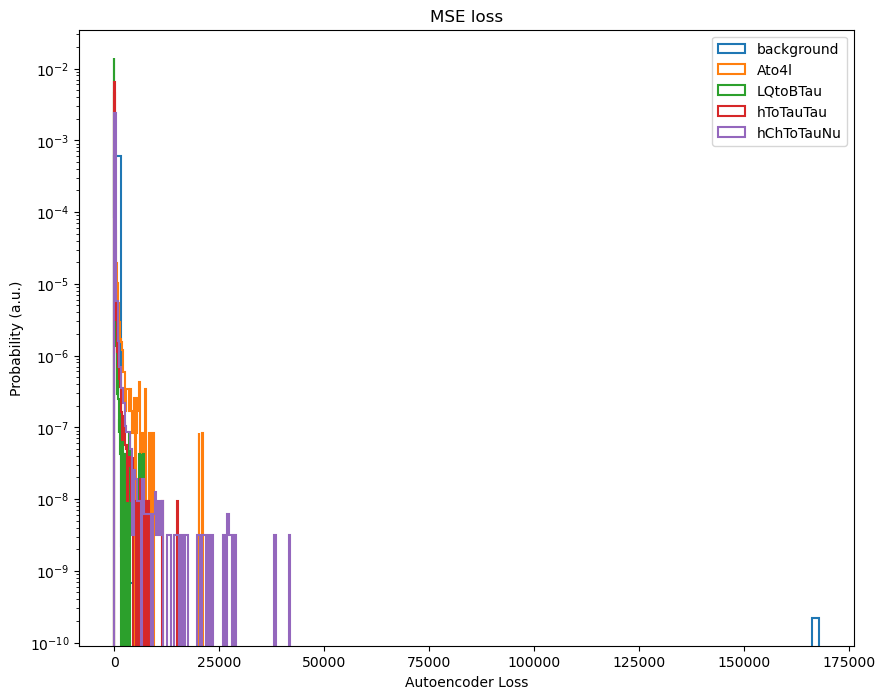

In [12]:
from matplotlib import pyplot as plt

bin_size=100
signal_labels = ["background", "Ato4l", "LQtoBTau", "hToTauTau", "hChToTauNu"]
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()


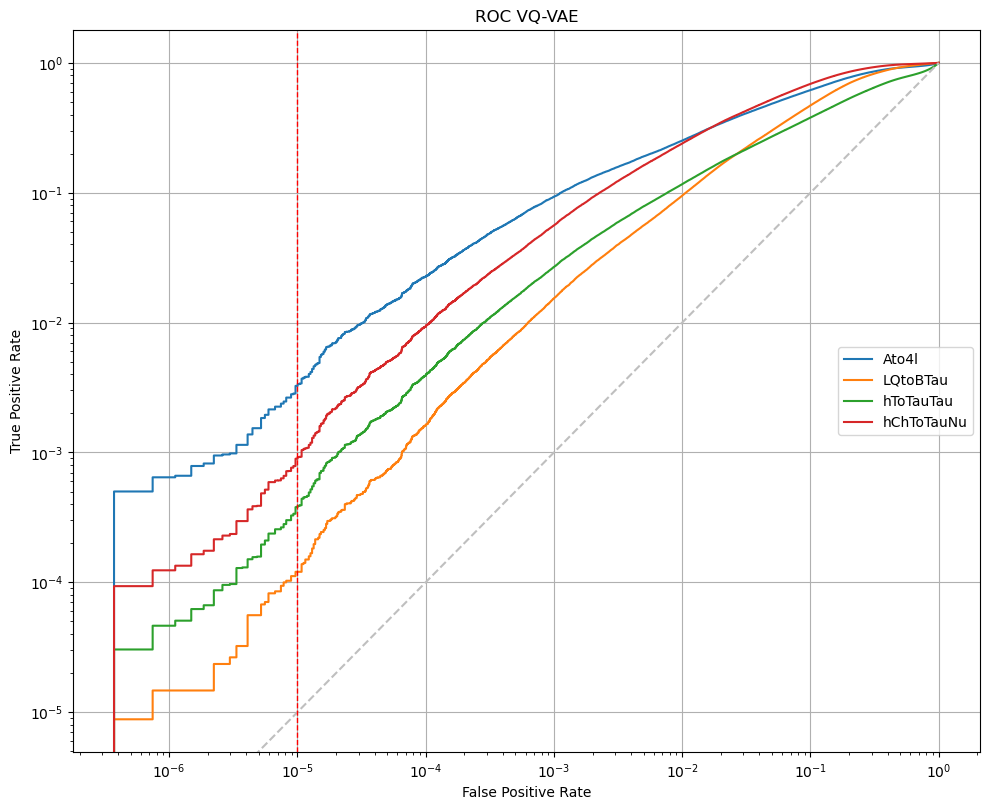

In [13]:
target_background = np.zeros(total_loss[0].shape[0])
#signal_labels = ["background"] + signal_labels
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(tpr_loss, fpr_loss)
    
    plt.plot(fpr_loss,tpr_loss, "-", linewidth=1.5, label = label)#plt.plot(tpr_loss,fpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC VQ-VAE")
plt.show()